# Data preparation

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
from datasets import load_dataset

dataset = load_dataset("Naveengo/flickr8k", trust_remote_code=True)
# Use NLLB to translate English to Thai
model = AutoModelForSeq2SeqLM.from_pretrained("wtarit/nllb-600M-th-en")
tokenizer = AutoTokenizer.from_pretrained("wtarit/nllb-600M-th-en")

device = 0 if torch.cuda.is_available() else "cpu"
translation_pipeline = pipeline(
    "translation", 
    model=model, 
    tokenizer=tokenizer, 
    src_lang="eng_Latn", 
    tgt_lang="tha_Thai", 
    max_length=400, 
    device=device,
    batch_size=8
)

In [2]:
def translate(text):
    result = translation_pipeline(text)
    return [res['translation_text'] for res in result]

dataset = dataset.map(lambda x: {"image": x["image"], "text": translate(x['text'])}, batched=True, batch_size=8)

Map:   0%|          | 0/8091 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


นักประกอบสีน้ําตาลยืนในน้ํา เตรียมการจับกระดูกของเขา


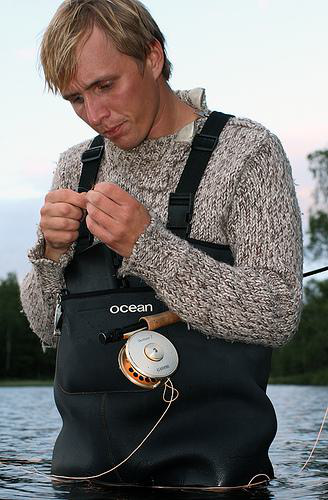

In [94]:
import random

idx = random.randint(0, len(dataset['train']))
print(dataset['train'][idx]['text'])
dataset['train'][idx]['image']

In [86]:
# dataset.push_to_hub("betteracs/flickr8k_th")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/8091 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/betteracs/flickr8k_th/commit/3b5aeded7f058c8410b101d46b014453f0338a24', commit_message='Upload dataset', commit_description='', oid='3b5aeded7f058c8410b101d46b014453f0338a24', pr_url=None, pr_revision=None, pr_num=None)

# Dataset & DataLoader

In [103]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader


class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset_name: str, processor, device):
        self.dataset = load_dataset(dataset_name, trust_remote_code=True)['train']
        self.processor = processor
        self.device = device

    def __len__(self):
        return len(self.dataset['text'])

    def __getitem__(self, idx):
        return {
            "feat": self.processor(images=self.dataset[idx]['image'], return_tensors="pt").to(self.device),
            "text": "รูปภาพของ " + self.dataset[idx]['text'],
        }


# Model

In [96]:
from transformers import AutoTokenizer, AutoImageProcessor, AutoModel, LlamaForCausalLM
import torch

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
train_dataset = ImageCaptioningDataset("betteracs/flickr8k_th", processor=processor, device="cuda")
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

train-00000-of-00001.parquet:   0%|          | 0.00/317M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

In [100]:
from transformers import AutoTokenizer, AutoModel, LlamaForCausalLM

class ImageCaptioningModel(torch.nn.Module):
    def __init__(self, image_model_name: str="facebook/dinov2-base", llm_model_name: str="meta-llama/Llama-3.2-1B", device="cuda"):
        super().__init__()
        
        self.dinov2 = AutoModel.from_pretrained(image_model_name).to(device)
        # Freeze the image model
        for param in self.dinov2.parameters():
            param.requires_grad = False
        self.dinov2.eval()

        self.llama_model = LlamaForCausalLM.from_pretrained(llm_model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
        self.tokenizer.add_special_tokens({
            'pad_token': '[PAD]',
            'cls_token': '[CLS]'
        })
        self.llama_model.resize_token_embeddings(len(self.tokenizer))

        hidden_size = self.llama_model.config.hidden_size
        # No resize image. Just reduce the dimension from 257 to 1 (B, 257, 768) -> (B, 10, 768)
        self.conv1 = torch.nn.Conv1d(257, 10, 1).to(device)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(768, hidden_size).to(device)

        self.device = device

    def generate(self, pixel_values, prompt):
        with torch.no_grad():
            image_features = self.dinov2(pixel_values).last_hidden_state # (B, 257, 768)
        
        image_features = self.conv1(image_features)
        image_features = self.relu(image_features)
        image_features = self.fc(image_features)

        input_ids = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=64).to(self.device)
        input_embeds = self.llama_model.model.embed_tokens(input_ids.input_ids).to(self.device) #self.llama_model(input_ids.) # (B, L, 768)

        input_embeds = torch.cat([image_features, input_embeds], dim=1).to(self.device) # (B, L+10, 768)
        out = self.llama_model.generate(inputs_embeds=input_embeds, pad_token_id=self.tokenizer.pad_token_id)
        return prompt + self.tokenizer.batch_decode(out, skip_special_tokens=True)

    def forward(self, pixel_values, text):
        with torch.no_grad():
            image_features = self.dinov2(pixel_values).last_hidden_state # (B, 257, 768)
        
        image_features = self.conv1(image_features)
        image_features = self.relu(image_features)
        image_features = self.fc(image_features)


        input_ids = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).to(self.device)
        input_embeds = self.llama_model.model.embed_tokens(input_ids.input_ids).to(self.device) # (B, L, 768)

        offset = (torch.ones((image_features.shape[0], 10)) * self.tokenizer.cls_token_id).to(self.device)
        labels = torch.cat([offset, input_ids.input_ids], dim=1).long()

        input_embeds = torch.cat([image_features, input_embeds], dim=1).to(self.device)  # (B, L+10, hidden_size)
        output = self.llama_model(inputs_embeds=input_embeds, labels=labels)

        return output

In [102]:
from lion_pytorch import Lion

model = ImageCaptioningModel()
print("Params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

# optimizer = torch.optim.AdamW(train_model.parameters(), lr=0.001, momentum=0.9)
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

Params:  1237395988


In [108]:
loss

10.302334547042847

In [109]:
from tqdm import tqdm

epochs = 5
batch_size = 2
num_steps = (len(train_dataloader) // batch_size) * epochs

loss = 0
sample = ""
description = "Training.. loss: {loss} {sample}"

with tqdm(total=num_steps, desc=description.format(loss=0, sample=sample)) as pbar:
    for epoch in range(epochs):
        model.train()
        avg_loss = 0

        for batch_no, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            outputs = model(
              pixel_values=batch['feat'].pixel_values.squeeze(1),
              text=batch["text"]
            )
            outputs.loss.backward()

            avg_loss += outputs.loss.cpu().detach().numpy()
            loss = avg_loss / (batch_no + 1)
            pbar.set_description(description.format(loss=loss, sample=sample))

            optimizer.step()
            pbar.update(1)

        model.eval()
        for batch_no, batch in enumerate(train_dataloader):
            outputs = model.generate(prompt=["รูปภาพของ "], pixel_values=batch["feat"].pixel_values[0].to("cuda"))
            sample = "".join(outputs)
            break


    

# for epoch in range(5):
#   train_model.train(True)
#   # for t, batch in enumerate(tqdm(train_dataloader)):
#   #     # break
#   #     optimizer.zero_grad()

#   #     out = train_model(
#   #        pixel_values=batch['feat'].pixel_values.squeeze(1),
#   #        text=batch["text"]
#   #     )
#   #     out.loss.backward()
#   #     # print(out.loss.cpu().detach().numpy(), end=" ")

#   #     optimizer.step()
#   #     if (t+1) % 100==0:
#   #       print(".", end="", flush=True)

#   train_model.eval()
#   if epoch % 1 == 0:
#     # mod.eval()
#     out = train_model.generate(prompt=["image of "], pixel_values=batch["feat"].pixel_values[0].to("cuda"))
#     print(out)


Training.. loss: 3.687774843099166 :   1%|          | 98/10115 [03:34<6:11:14,  2.22s/it] 